In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from IPython.display import display


In [2]:
raw = pd.DataFrame.from_csv('mean-stdev-raw.csv')
norm = pd.DataFrame.from_csv('mean-stdev-norm.csv')
intra = pd.DataFrame.from_csv('mean-stdev-intra.csv')
inter = pd.DataFrame.from_csv('mean-stdev-inter.csv')

tags = np.array(['P'] * 10 + ['S'] * 10)
labels = ['P', 'S']
dfs = [raw, norm, intra, inter]
colors = ['darkorange', 'r']

In [3]:
def calcAndPlotROCCurve(ax, data, tags, trueLabel, color, title):
    fpr, tpr, thresholds = metrics.roc_curve(tags, data, pos_label = trueLabel)
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, color = color, lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Random Guess')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve ' + title + ', True label = ' + trueLabel)
    ax.legend(loc='lower right')

def univariate1a(df):
    for colName in df.columns:
        fig, axs = plt.subplots(1, 2, figsize = (20,5))
        for i, ax in enumerate(axs):
            calcAndPlotROCCurve(ax, df[colName], tags, labels[i], colors[i], colName)
        plt.show()

def univariate1b(df):
    for colName in df.columns:
        sss = StratifiedShuffleSplit(n_splits = 1, test_size = 4)
        for cross_val_index, test_index in sss.split(df[colName], tags):
            X_cross_val, y_cross_val = df[colName].as_matrix()[cross_val_index], tags[cross_val_index]
            X_test, y_test = df[colName].as_matrix()[test_index], tags[test_index]

        sss = StratifiedShuffleSplit(n_splits = 50, test_size = 4)
        for train_index, val_index in sss.split(X_cross_val, y_cross_val):
            X_train, y_train = X_cross_val[train_index], y_cross_val[train_index]
            X_val, y_val = X_cross_val[val_index], y_cross_val[val_index]
            clf = LogisticRegression()
            clf.fit(X_train.reshape(-1, 1), y_train)
            predictions = clf.predict(X_val.reshape(-1, 1))

        clf = LogisticRegression()
        clf.fit(X_cross_val.reshape(-1, 1), y_cross_val)
        decision_function = clf.decision_function(X_test.reshape(-1, 1))

        fig, axs = plt.subplots(1, 2, figsize = (20,5))
        for i, ax in enumerate(axs):
            calcAndPlotROCCurve(ax, decision_function, y_test, labels[i], colors[i], colName)
        plt.show()


## Para cada feature, computar la curva ROC y graficarla

### Features: Mean and StDev para cada Banda de frecuencias para los datos desnormalizados

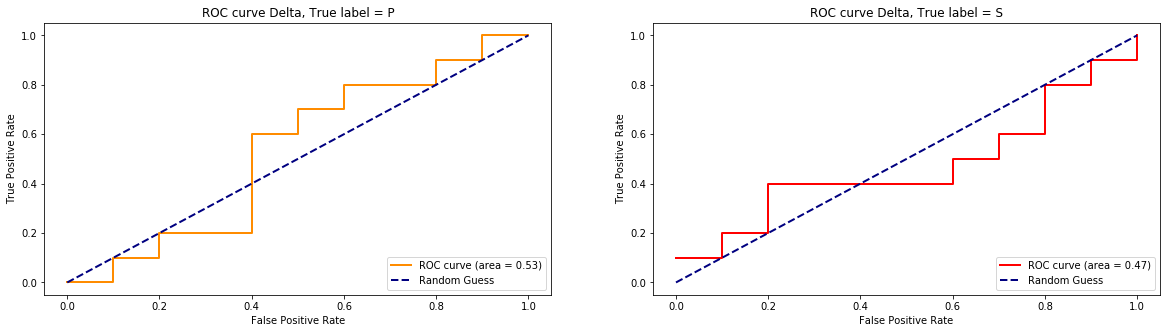

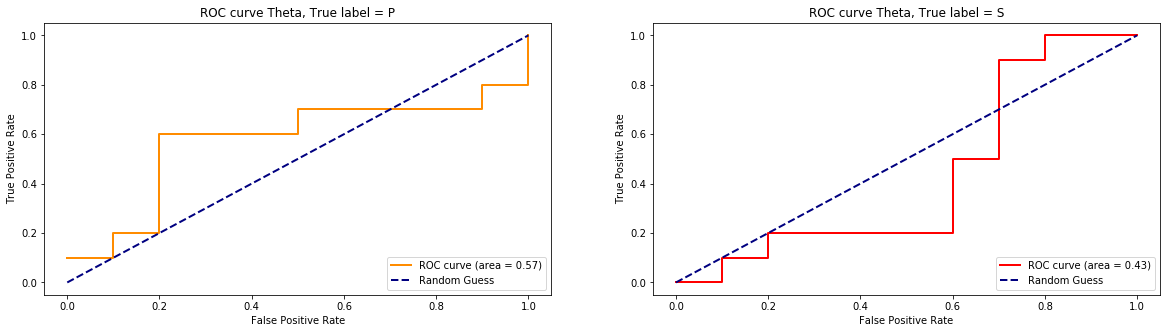

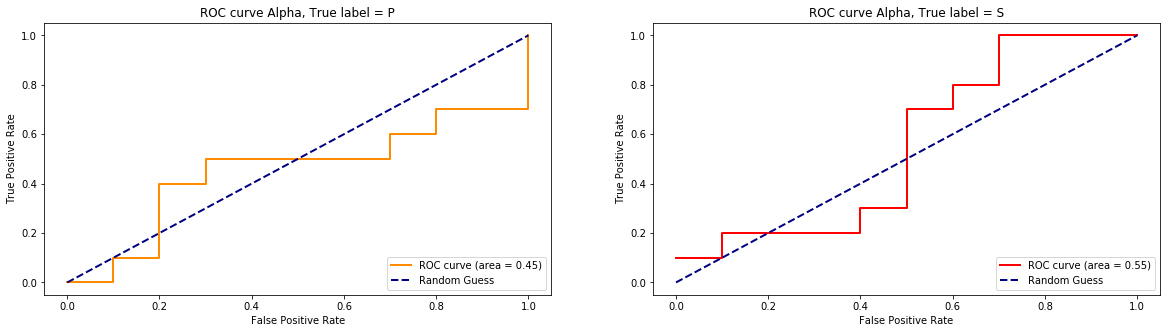

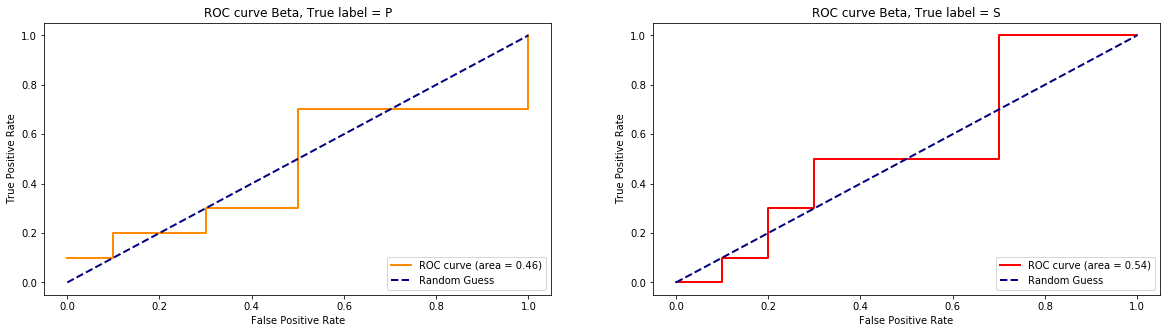

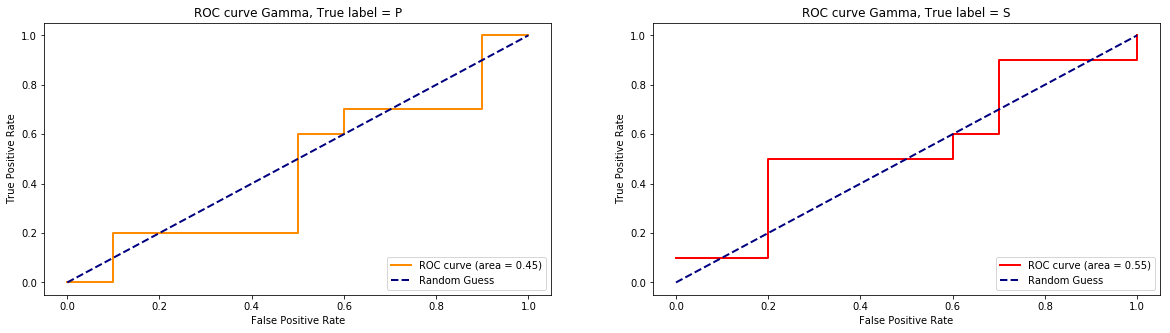

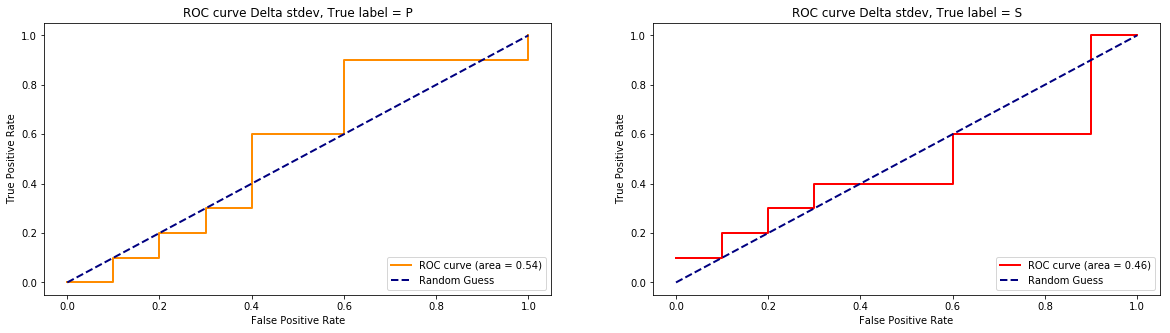

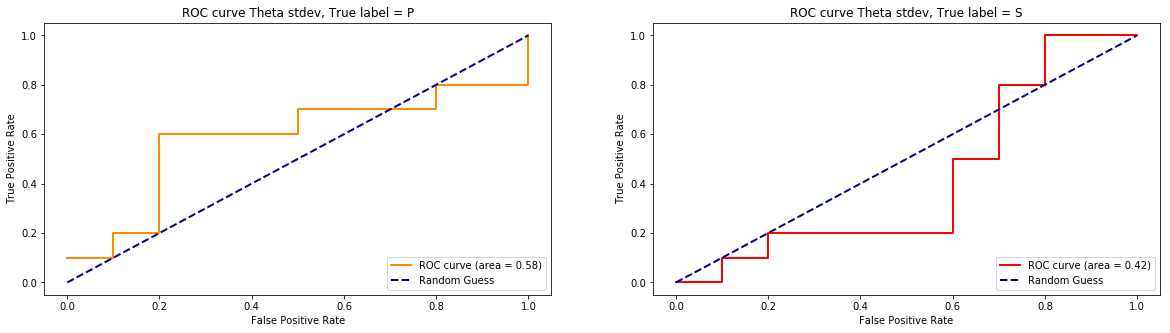

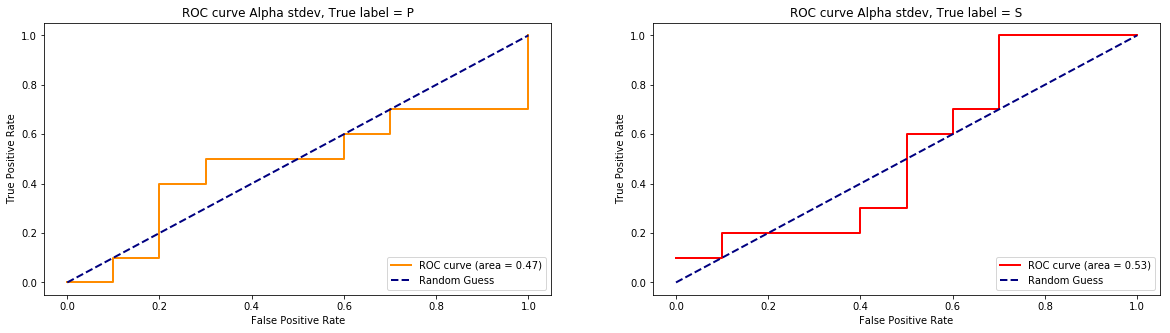

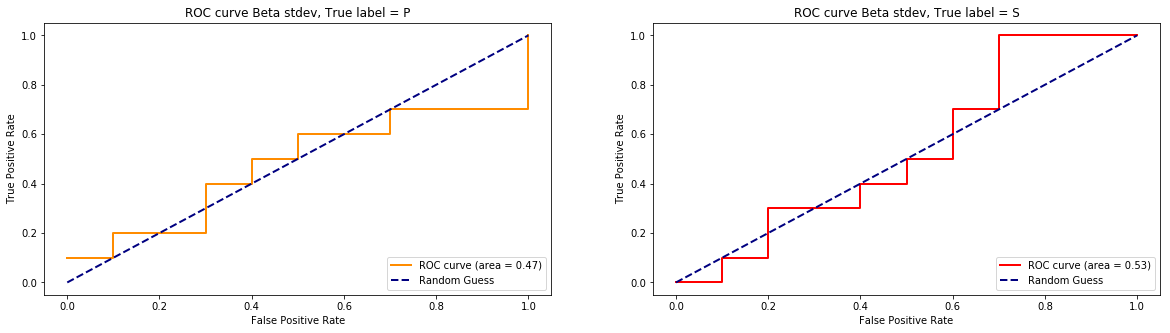

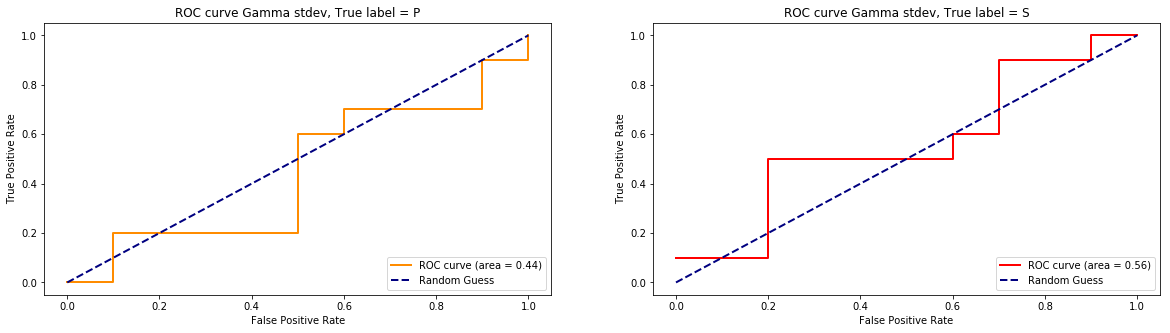

In [4]:
univariate1a(raw)


### Features: Mean and StDev para cada Banda de frecuencias para los datos normalizados

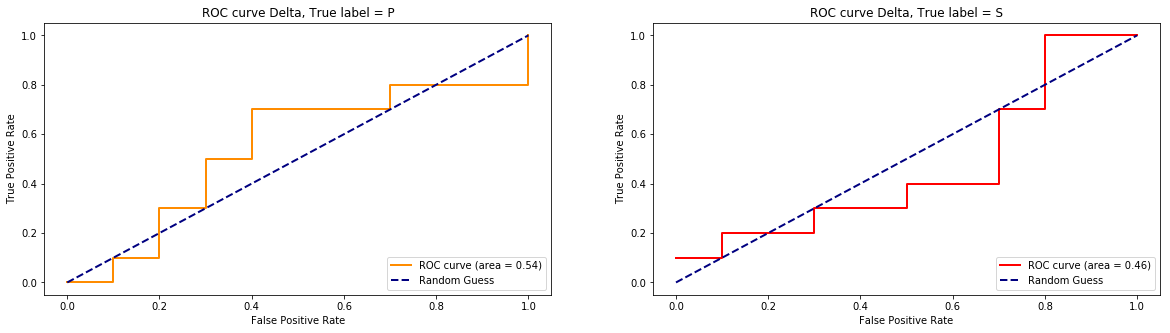

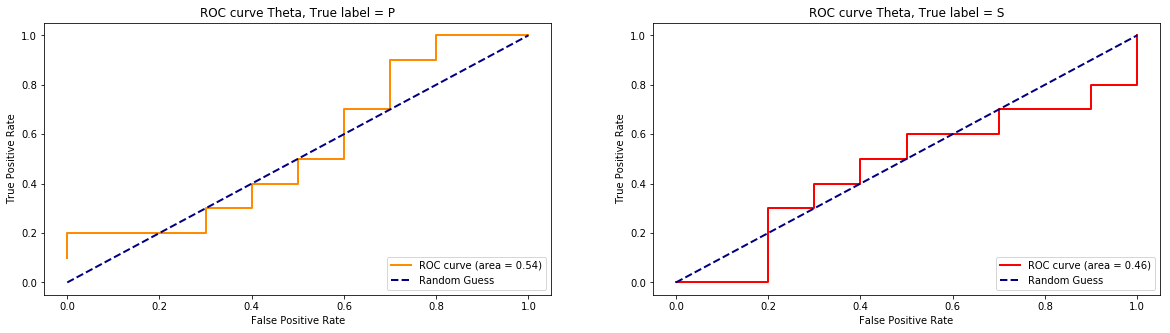

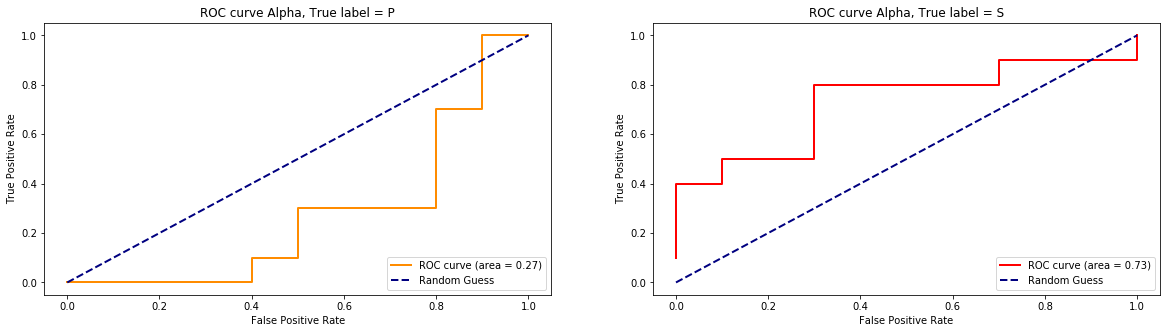

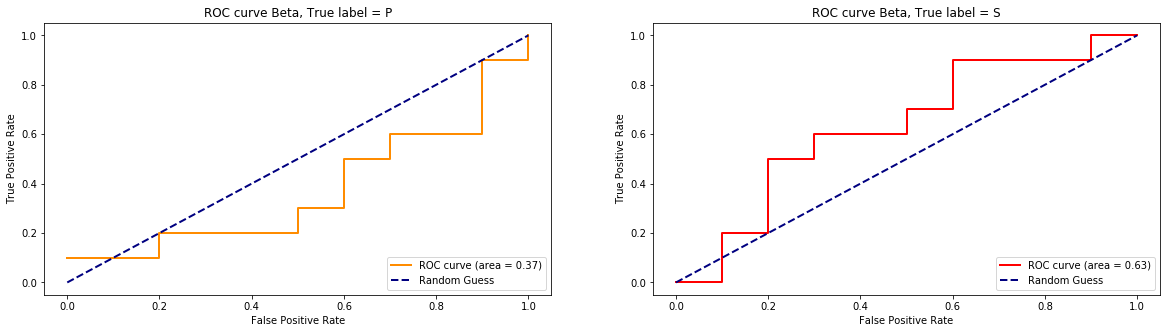

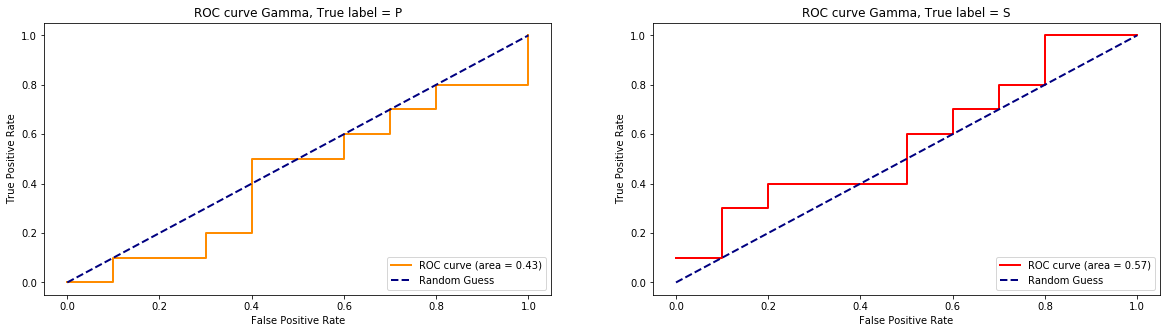

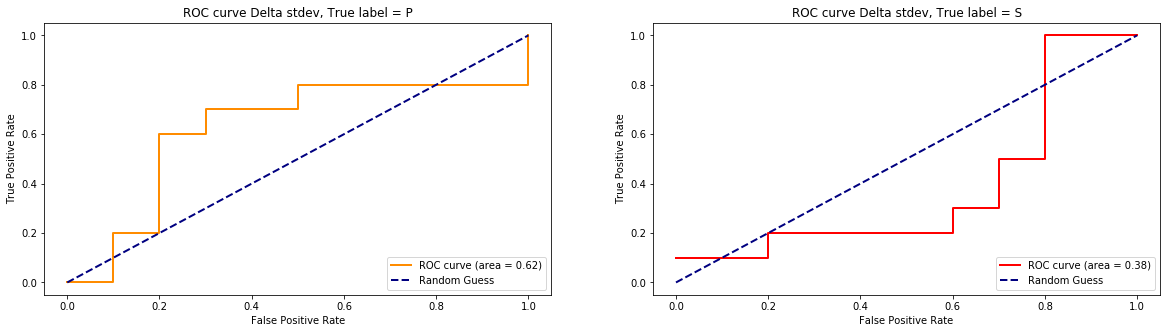

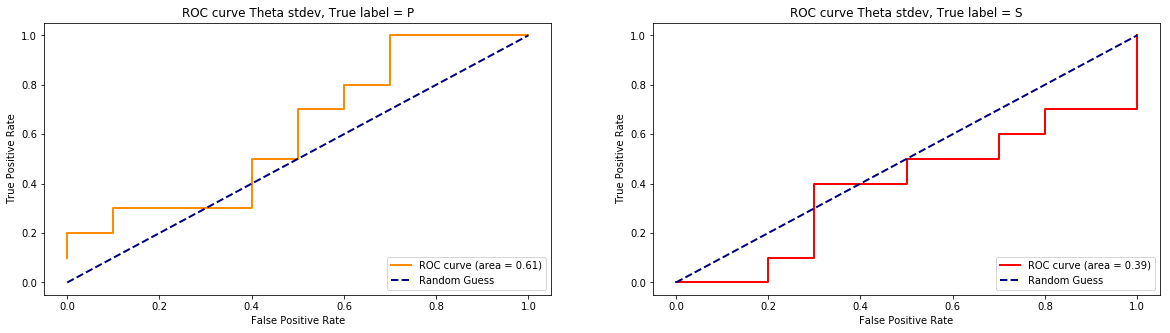

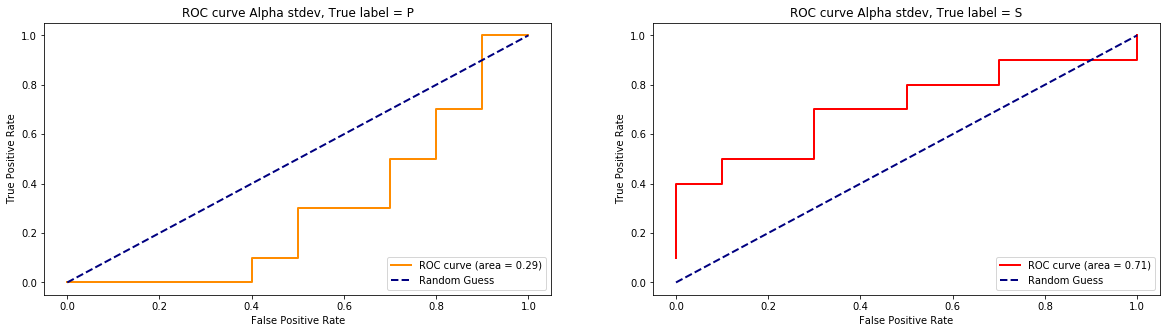

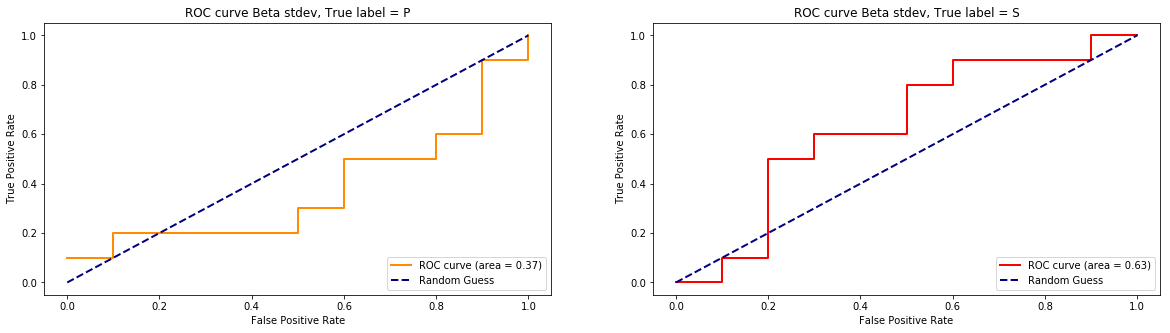

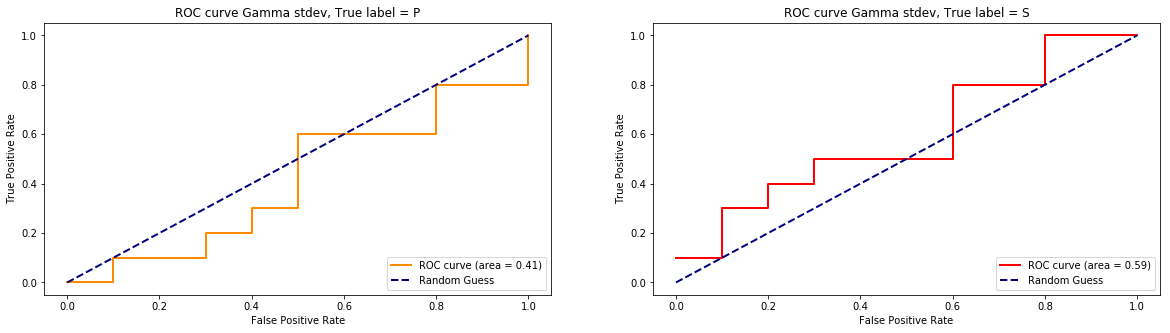

In [5]:
univariate1a(norm)


### Features: Mean and StDev para la medida intra-electrodo (entropía)

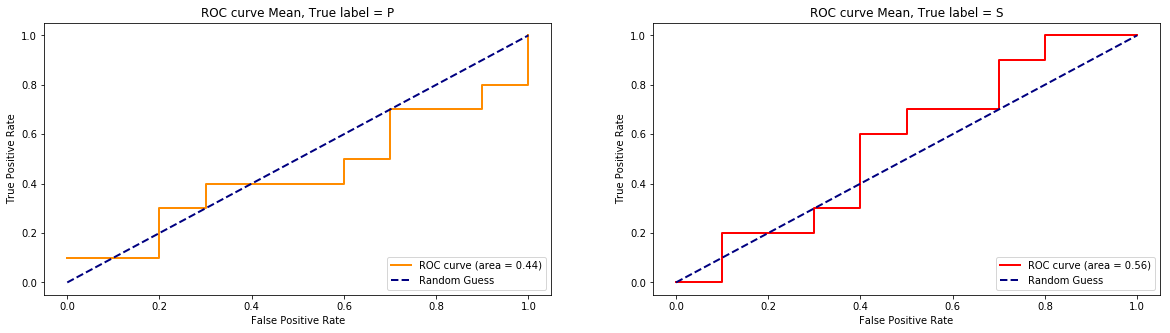

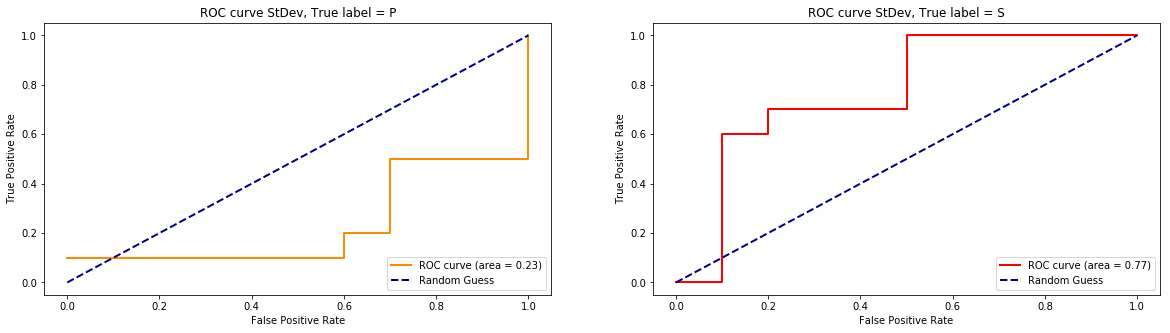

In [6]:
univariate1a(intra)


### Features: Mean and StDev para la medida inter-electrodo (poner_nombre_aqui)

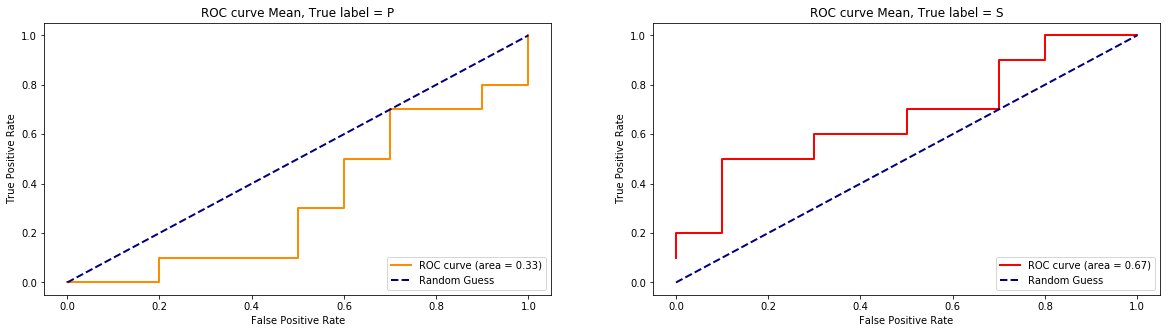

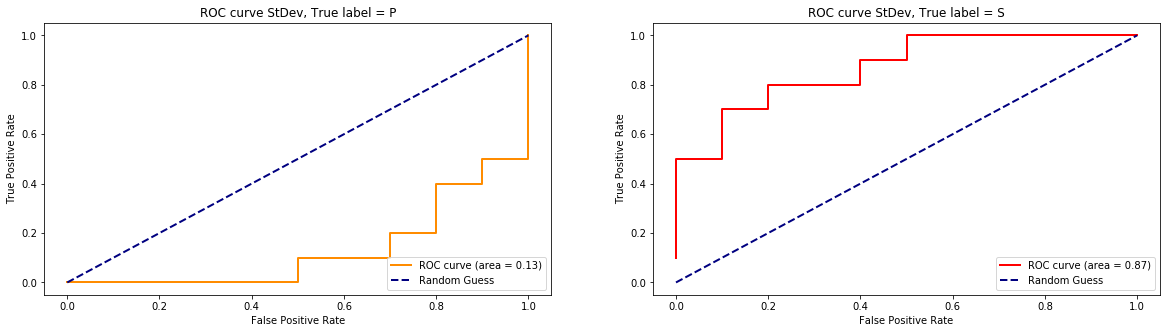

In [8]:
univariate1a(inter)


## Utilizando una técnica de cross validation, estimar la performance de un classificador Logistic Regression para cada feature y graficar la curva ROC correspondiente

### Features: Mean and StDev para cada Banda de frecuencias para los datos desnormalizados

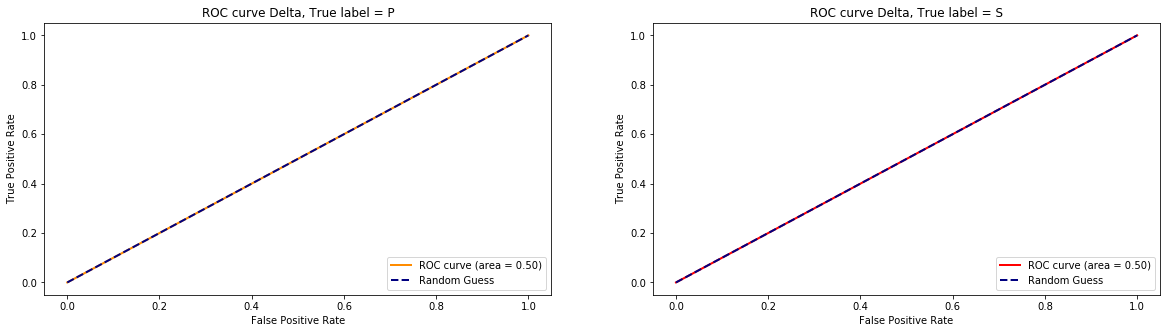

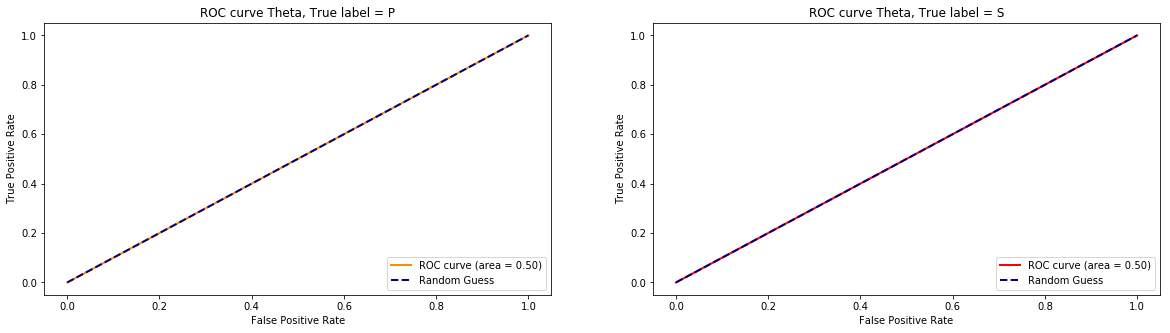

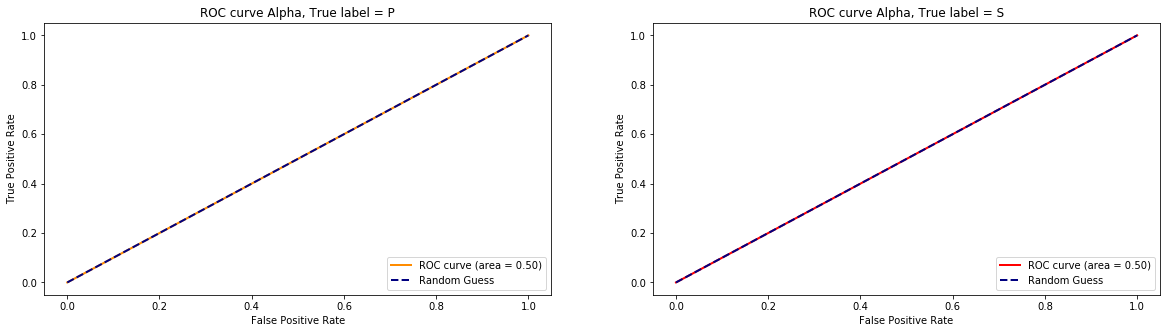

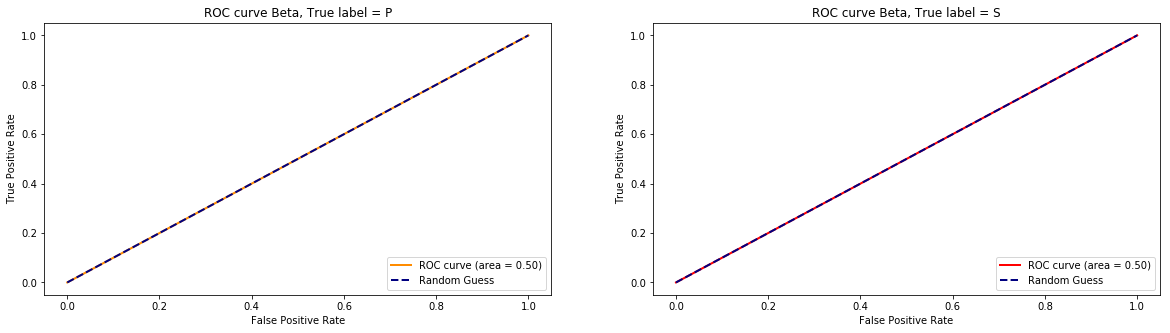

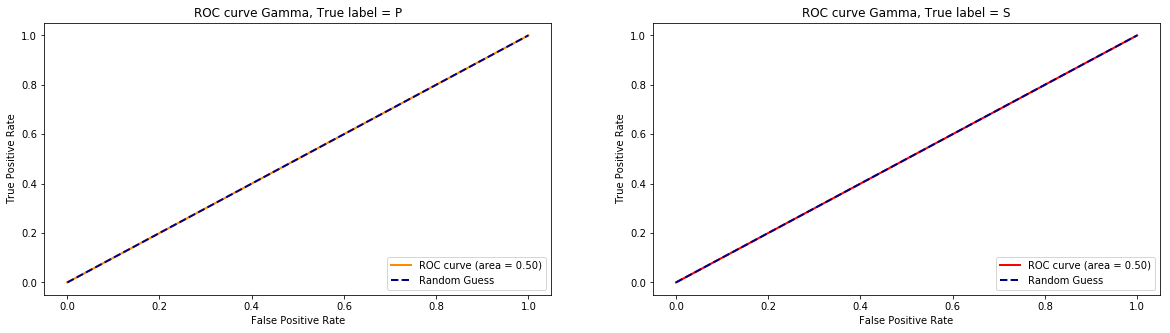

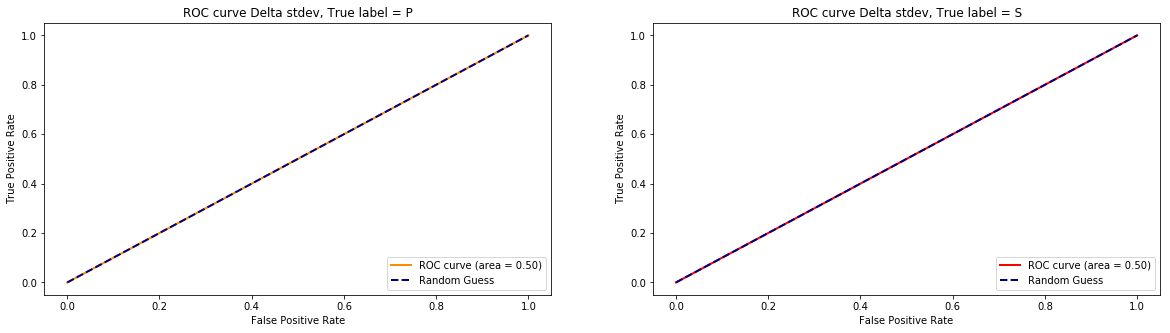

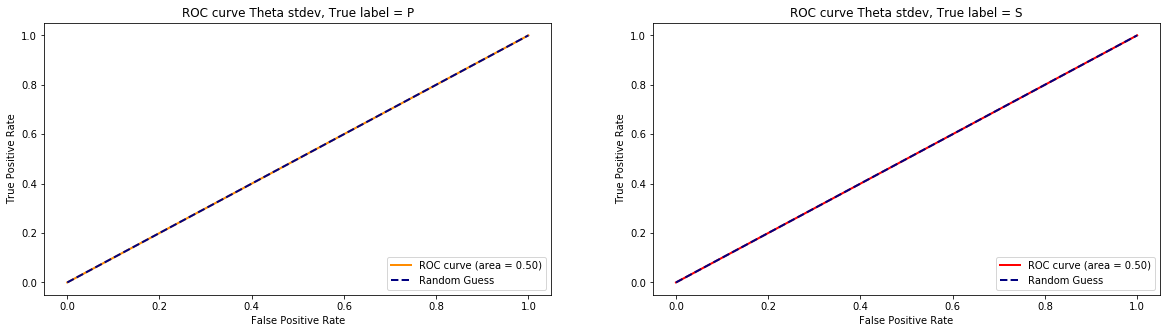

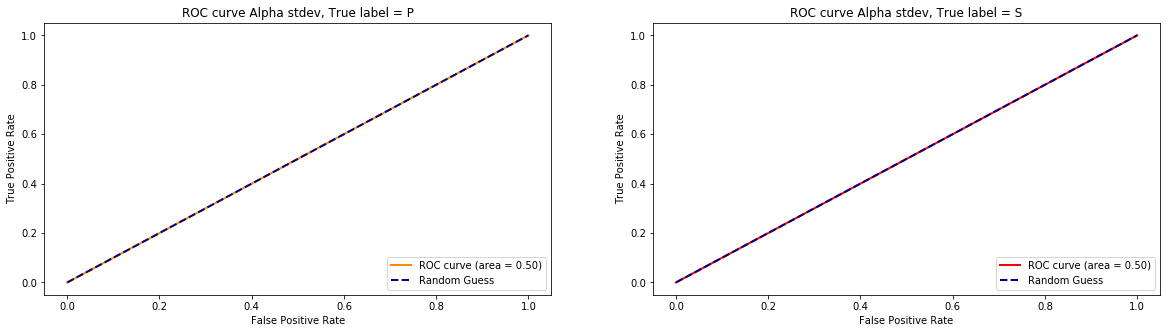

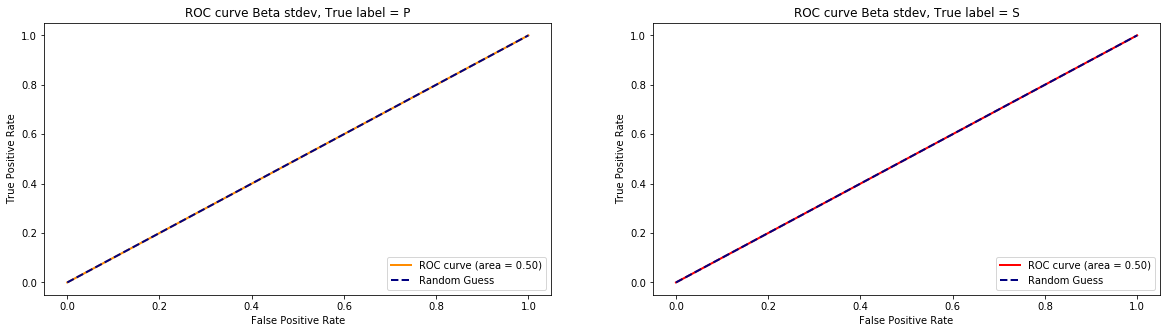

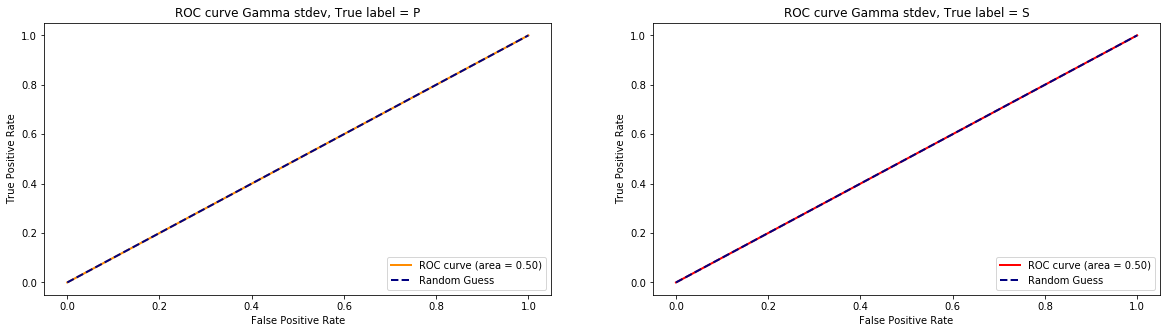

In [9]:
univariate1b(raw)


### Features: Mean and StDev para cada Banda de frecuencias para los datos normalizados

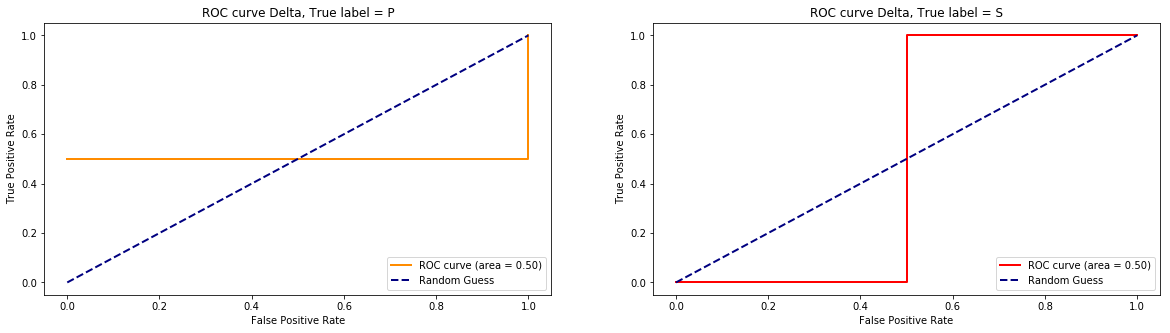

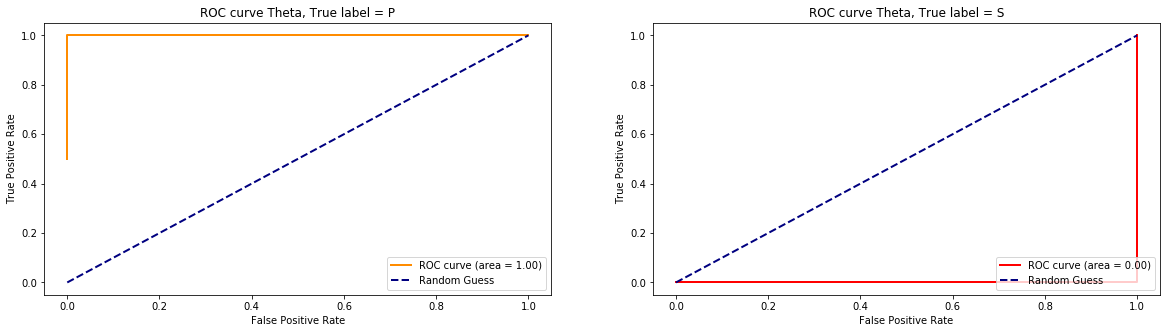

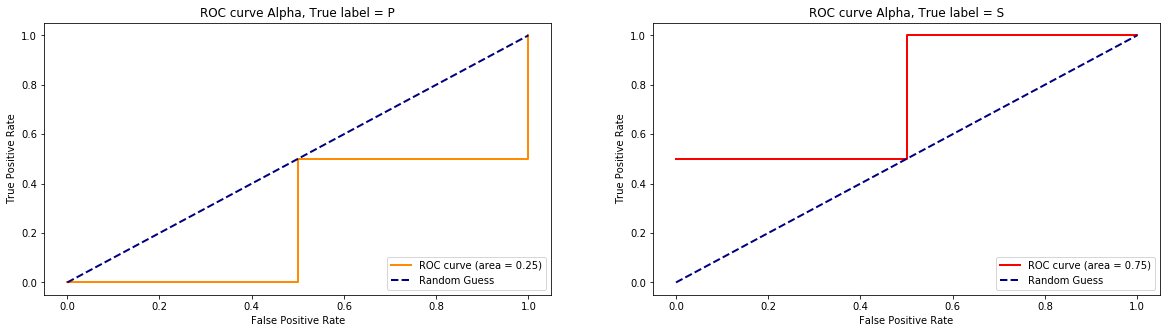

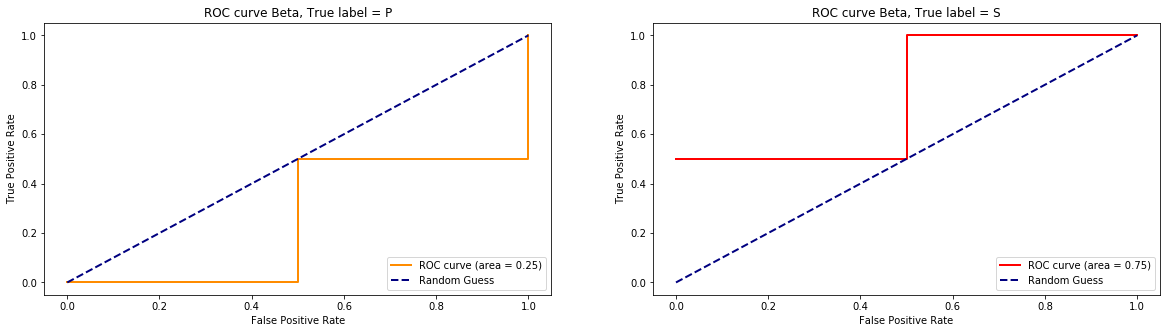

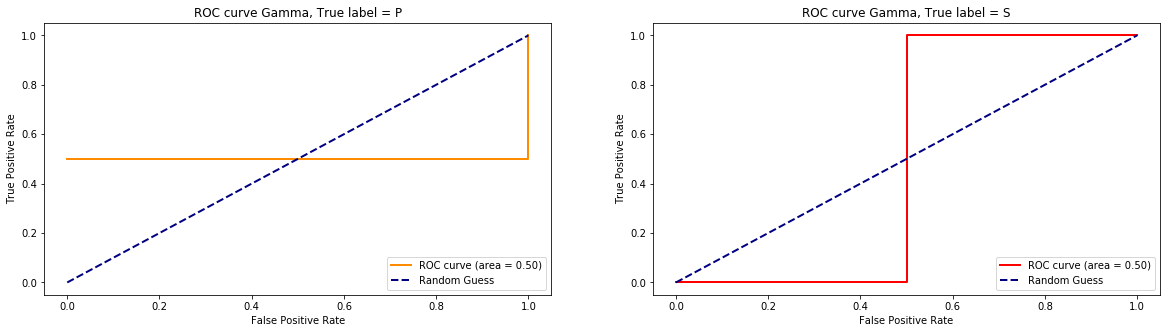

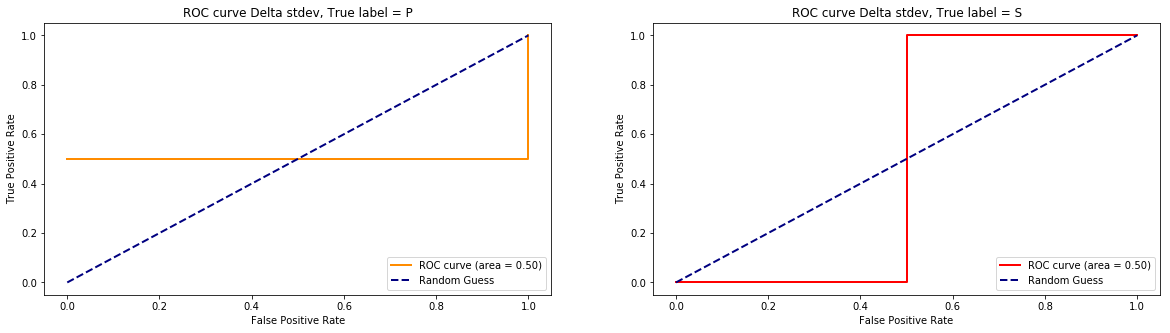

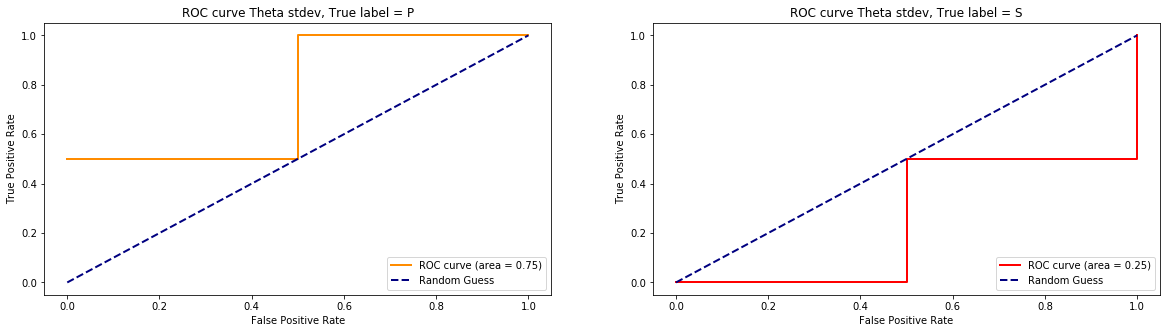

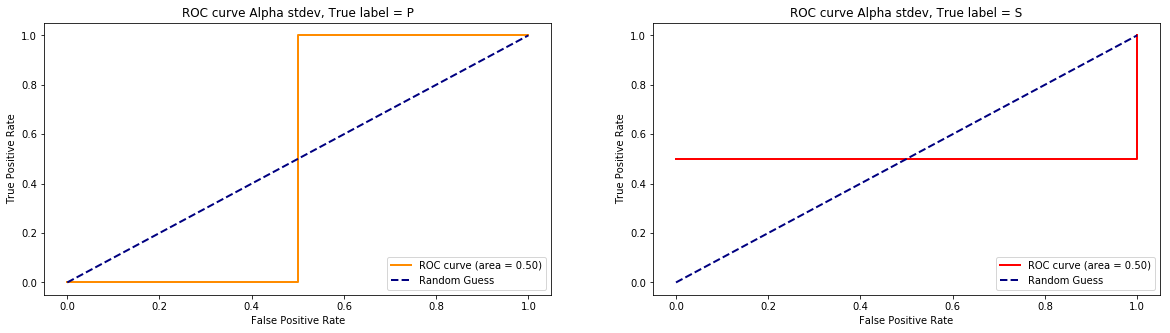

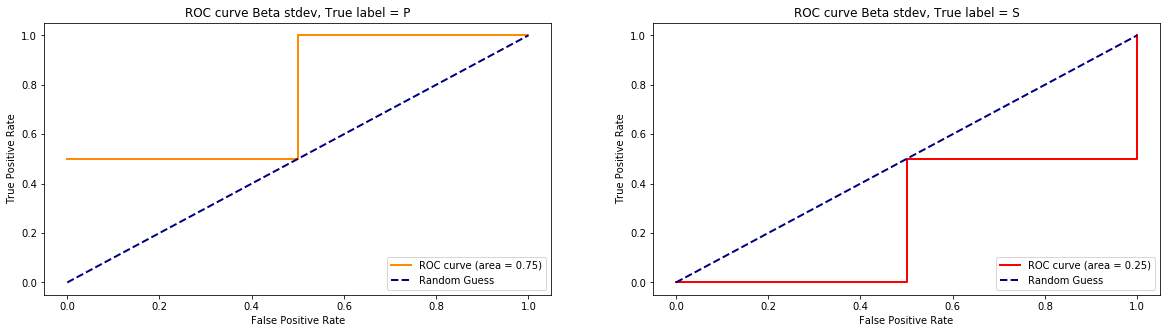

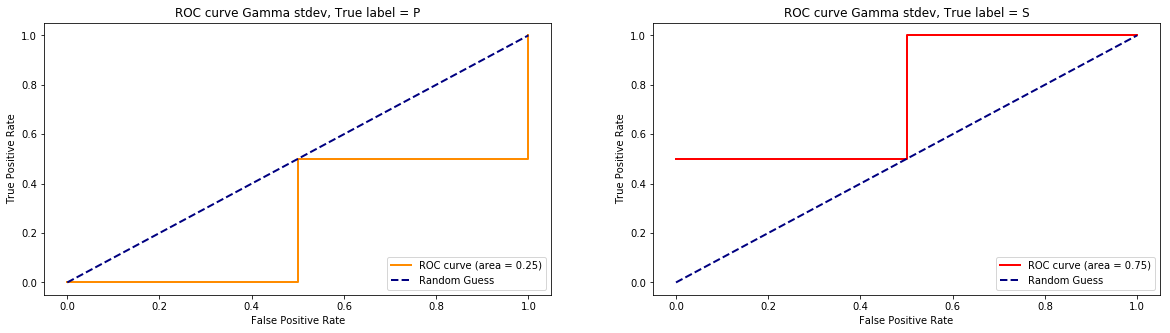

In [10]:
univariate1b(norm)


### Features: Mean and StDev para la medida intra-electrodo (entropía)

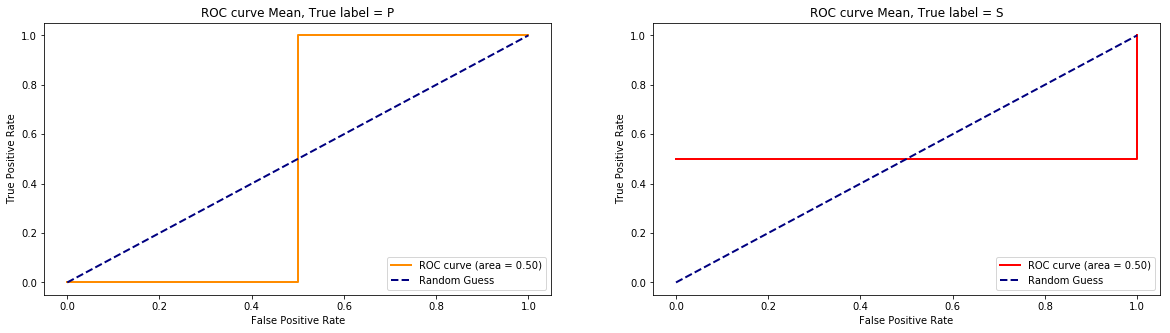

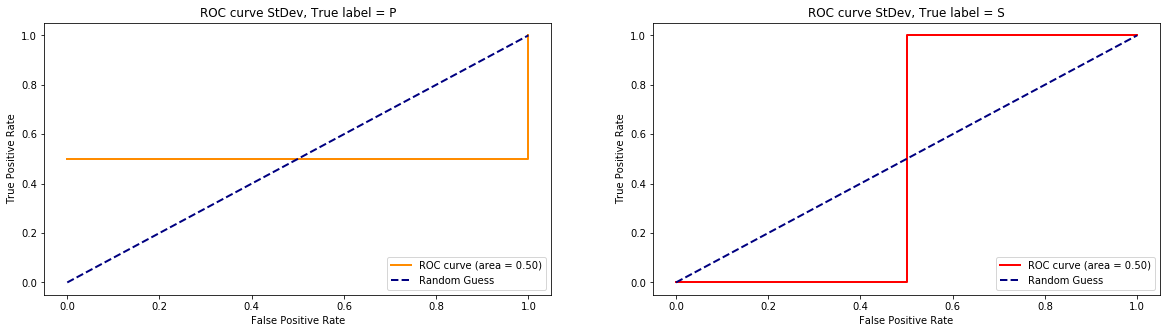

In [16]:
univariate1b(intra)


### Features: Mean and StDev para la medida inter-electrodo (poner_nombre_aqui)

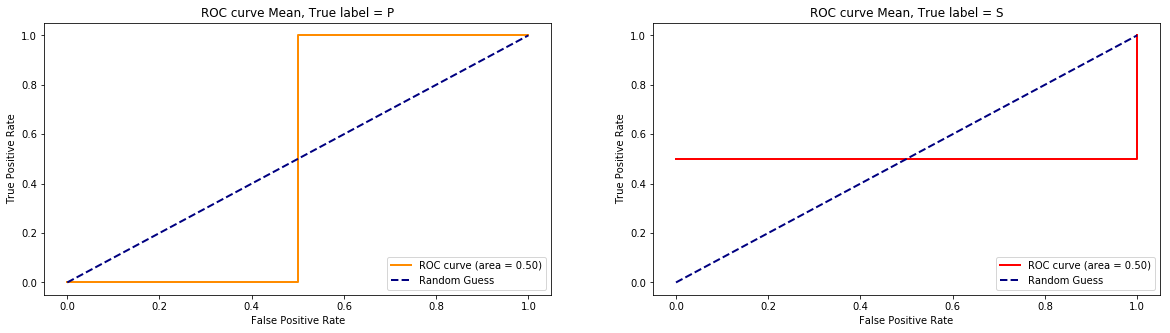

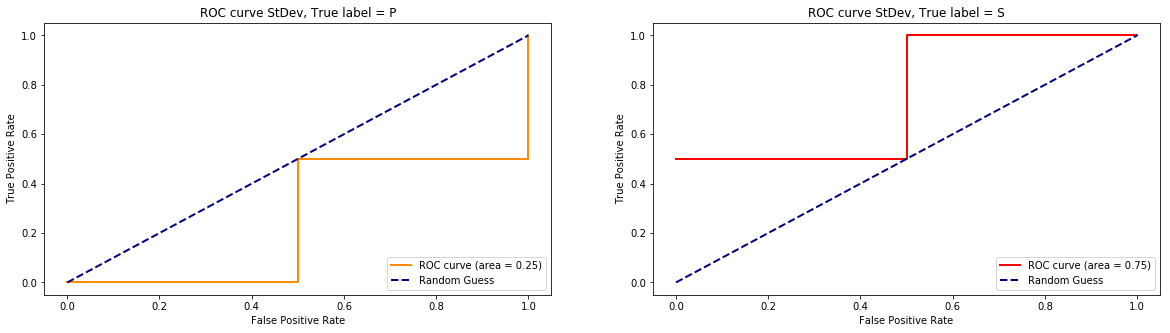

In [14]:
univariate1b(inter)


### ¿Cuál es su conclusión respecto a los resultados obtenidos en el punto anterior?